In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn # scikit-learn kutubxonasi
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn import metrics 

# Bizning ushbu modelni qurishdagi vazifamiz **`UNS`**(o'quvchilarning bilim darajasi) ni bashorat qilish 

## **Ta'rif**

- `STG`	--->  *Maqsad ob'ekti materiallarini o'rganish vaqti darajasi*

- `SCG`	--->  *Maqsad ob'ekti materiallari uchun foydalanuvchining takrorlanish soni*

- `STR`	--->  *Maqsad ob'ekti bilan bog'liq ob'ektlar uchun foydalanuvchining o'rganish vaqti darajasi*

- `LPR`	--->  *Maqsad ob'ekti bilan bog'liq ob'ektlar uchun foydalanuvchining imtihon natijalari*

- `PEG`	--->  *Maqsad ob'ektlari uchun foydalanuvchining imtihon samaradorligi*

- `UNS`	--->  *Foydalanuvchining bilim darajasi (juda past, past, o'rta, yuqori)*

In [2]:
!pip install xlrd==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 29.2 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


excel faylni o'qish uchun `xlrd` ning yangiroq versiyasini o'rnatib oldik.

In [3]:
url = "https://github.com/farkhod-developer/Datasets_Practice/blob/main/Predict_student'_%20knowledge_level.xls?raw=True"
df = pd.read_excel(url)
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


In [4]:
df.shape

(403, 6)

datasetimiz 403 ta qator 6 ustundan iborat ekan

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     403 non-null    float64
 1   SCG     403 non-null    float64
 2   STR     403 non-null    float64
 3   LPR     403 non-null    float64
 4   PEG     403 non-null    float64
 5    UNS    403 non-null    object 
dtypes: float64(5), object(1)
memory usage: 19.0+ KB


In [6]:
# takrorlangan qiymatlar yo'q
df.duplicated().sum()

0

In [7]:
df.describe()

,STG,SCG,STR,LPR,PEG
count,403.000000,403.000000,403.000000,403.000000,403.000000
mean,0.353141,0.355940,0.457655,0.431342,0.456360
std,0.212018,0.215531,0.246684,0.257545,0.266775
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.265000,0.250000,0.250000
50%,0.300000,0.300000,0.440000,0.330000,0.400000
75%,0.480000,0.510000,0.680000,0.650000,0.660000
max,0.990000,0.900000,0.950000,0.990000,0.990000


In [8]:
# ushbu ustunda qandaydur xatolik mavjud
df['UNS'].value_counts()

KeyError: ignored

In [9]:
df.rename(columns={' UNS': 'UNS'}, inplace=True)

Ushbu ustunning oldida bo'sh probel bor ekan, ushbu probelni olib tashlaymiz

In [10]:
df['UNS'].value_counts()

Low         129
Middle      122
High        102
Very Low     26
very_low     24
Name: UNS, dtype: int64

bizga kerakli bo'lgan matnli ustunimizni raqamlarga o'zgartirib olamiz

In [12]:
df['UNS'].replace("Very Low",0, inplace=True)
df['UNS'].replace("very_low",0, inplace=True)
df['UNS'].replace("Low",1, inplace=True)
df['UNS'].replace("Middle",2, inplace=True)
df['UNS'].replace("High",3, inplace=True)
df['UNS'].value_counts()

1    129
2    122
3    102
0     50
Name: UNS, dtype: int64

In [13]:
# UNS ustuniga nisbatan barcha ustunlarning korrelyatsiyasini ko'rishimiz mumkin
df.corrwith(df['UNS']).abs().sort_values(ascending=False)

UNS    1.000000
PEG    0.919456
SCG    0.249095
LPR    0.247968
STG    0.217477
STR    0.203452
dtype: float64

In [14]:
# bu ham korrelyatsiyani vizualizatsiya ko'rinishida
corr_matrix = df.corr().abs()
corr_matrix.style.background_gradient(cmap='coolwarm')

,STG,SCG,STR,LPR,PEG,UNS
STG,1.000000,0.049023,0.051889,0.113957,0.198629,0.217477
SCG,0.049023,1.000000,0.121235,0.119716,0.193566,0.249095
STR,0.051889,0.121235,1.000000,0.083423,0.148338,0.203452
LPR,0.113957,0.119716,0.083423,1.000000,0.039283,0.247968
PEG,0.198629,0.193566,0.148338,0.039283,1.000000,0.919456
UNS,0.217477,0.249095,0.203452,0.247968,0.919456,1.000000


### ML ga tayyorlaymiz

`UNS` ustunimizni aloxida `y` ga ajratib oldik

In [15]:
X = df.drop('UNS', axis=1).values
y = df['UNS']

Standartizatsiya qildik

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## ML

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# k-NN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(10) # k-ni qiymati

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [18]:
y_predict = knn.predict(X_test)

## Baholash

### Jaccard index

In [19]:
from sklearn.metrics import jaccard_score

jaccard_score(y_test, y_predict, average="weighted")

0.7305476416587526

`Jaccard index` orqali tekshirganimizda aniqlik 73% chiqyapti bu yaxshiu ko'rsatkich emas

### Confusion matrix

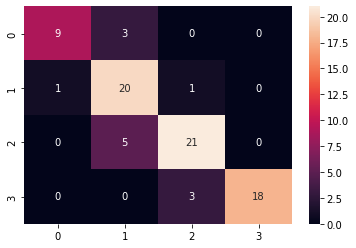

In [20]:
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.show()

In [21]:
confusion_matrix(y_test, y_predict)

array([[ 9,  3,  0,  0],
       [ 1, 20,  1,  0],
       [ 0,  5, 21,  0],
       [ 0,  0,  3, 18]])

### Precision, recall, F1

In [22]:
precision = precision_score(y_test, y_predict, average="weighted")
recall = recall_score(y_test, y_predict, average="weighted")
f1 = f1_score(y_test, y_predict, average="weighted")
accuracy = accuracy_score(y_test, y_predict)
print(f"precision= {precision:.2f}%\nrecall= {recall:.2f}%\nf1={f1:.2f}%\naccuracy={accuracy:.2f}%")

precision= 0.86%
recall= 0.84%
f1=0.84%
accuracy=0.84%


modelimiz 84% aniqlikda ishlamoqda, bu qanchalik yaxshi yoki yomon natija ekanligiga bir nima deyish qiyin, bu datasetga bog'liq, bizning datasetimiz bor yo'g'i 403 ta qatordan iborat, dataset qanchalik ko'p bo'lsa aniqlik ham shunchalik ko'p bo'lishi mumkin

In [26]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.71      0.91      0.80        22
           2       0.84      0.81      0.82        26
           3       1.00      0.86      0.92        21

    accuracy                           0.84        81
   macro avg       0.86      0.83      0.84        81
weighted avg       0.86      0.84      0.84        81



### Cross-validation yordamida tekshiramiz

In [24]:
# Cross validation
from sklearn.model_selection import cross_val_predict
predict = cross_val_predict(estimator = knn, X = X, y = y, cv = 10)

# Modelni baholash
from sklearn.metrics import classification_report
print("Classification Report: \n",classification_report(y, predict))

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.58      0.71        50
           1       0.73      0.95      0.82       129
           2       0.76      0.75      0.76       122
           3       0.93      0.75      0.83       102

    accuracy                           0.79       403
   macro avg       0.83      0.76      0.78       403
weighted avg       0.81      0.79      0.79       403



`Cross validation` yordamida tekshirganimizda `79%` aniqlikda chiqmoqda.  
Hulosa qiladigan bo'lsak aynan bir optimal yechim yo'q, bizning modelimizga qarab turli algoritmlardan turli yechimlarni olishimiz mumkin.